In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
# remove top and right axis from plots
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False

# remove all edges
# mpl.rcParams["axes.edgecolor"] = "none"

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

In [26]:
def get_log_probs(event_path):
    event_acc = EventAccumulator(str(event_path))
    event_acc.Reload()
    # print(event_acc.Tags()) # Show all tags in the log file

    _, step_nums, training_log_probs = zip(*event_acc.Scalars('training_log_probs'))
    _, _, validation_log_probs = zip(*event_acc.Scalars('validation_log_probs'))
    _, _, best_validation_log_prob = zip(*event_acc.Scalars('best_validation_log_prob'))
    return step_nums, training_log_probs, validation_log_probs, best_validation_log_prob

In [52]:
train_id = 6
# the log path
log_dir = Path('../src/train/logs')
event_path = log_dir / 'logs_15_p1' / f'log_sample_Rchoices{train_id}' / \
             'events.out.tfevents.1678576456.snnmonster.3771680.0'
title=f'log_sample_Rchoice{train_id}'

log_dir = Path('../src/train/logs')
event_path = log_dir / 'logs_15_p1' / f'log_test' / \
             'events.out.tfevents.1678642099.snnmonster.3800478.0'
title=f'log_test'

(-10.0, 7.0)

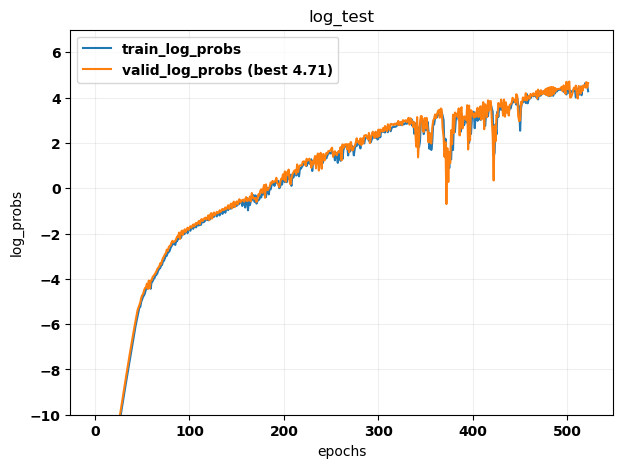

In [53]:
step_nums, training_log_probs, validation_log_probs, best_validation_log_prob = get_log_probs(event_path)

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(step_nums, training_log_probs, label='train_log_probs')
plt.plot(step_nums, validation_log_probs, label=f'valid_log_probs (best {best_validation_log_prob[0]:.2f})')
plt.legend()
plt.title(title)
plt.xlabel('epochs')
plt.ylabel('log_probs')
plt.grid(alpha=0.2)
plt.ylim([-10, 7])